In [31]:
import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pylab as plt #for visualization
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from collections import defaultdict
from matplotlib.pylab import rcParams
import re

rcParams['figure.figsize'] = 15, 9

pytrends = TrendReq(hl='en-US', tz=360)

In [2]:
result = None
state_score = None
trend_score_sorted = None
rel_data = None
df_com = None

# Function to Get Data from Google

In [3]:
def get_data(disease_name, Date, Location):
    # cat = 45 means health category
    x = None
    pytrends.build_payload(disease_name, cat=45, timeframe=Date, geo=Location, gprop='')
    df = pytrends.interest_over_time()
    x = pytrends.interest_by_region(resolution='India')
    if 'isPartial' in df.columns:
        df.drop(columns=['isPartial'],inplace=True)
    # print(x)
    return df, x

# Function to get Individual Data, Relative Data and StateWise Score

In [4]:
def final_data(content, result, Date, Location, state_score, rel_data):
    for i in content:
        temp_list = []
        temp_list.append(i) 
        series, score = get_data(temp_list,Date, Location)
        try:
            if result is None:
                result = series
            else:
                result = pd.merge(result,series,on=['date'])
        except:
            pass
        
        try:
            if state_score is None:
                state_score = score
            else:
                state_score = pd.merge(state_score,score,on=['geoName'])
        except:
            pass
        temp_rel_list = ['fever']
        temp_rel_list.append(i)
        df_rel, st = get_data(temp_rel_list,'today 1-m',Location)
        try:
            if rel_data is None:
                rel_data = df_rel
            else:
                rel_data = pd.merge(rel_data,df_rel,on=['date'])
        except:
            pass
        # print(rel_data)

    return result, state_score,rel_data

In [5]:
# plt.plot(result)

In [6]:
# decomposition = seasonal_decompose(result,freq=10) 
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

# plt.subplot(511)
# plt.plot(result, label='Original')
# plt.legend(loc='best')

# plt.subplot(512)
# plt.plot(trend, label='Trend')
# plt.legend(loc='best')

# plt.subplot(513)
# plt.plot(seasonal, label='Seasonality')
# plt.legend(loc='best')

# plt.subplot(514)
# plt.plot(residual, label='Residuals')
# plt.legend(loc='best')

# Rank based on Trends | Method1

In [7]:
def Trend_Score_1(result,content,dateLen):
    trend_partition = 0.2
    trendLen = int(dateLen*trend_partition)
    baseLen = dateLen - trendLen
    trend_score = {}
    def moving_av(l, n):
        observations = len(l[-n:])
        return sum(l[-n:]) / float(observations)
    for i in content:
        d5_moving_av = moving_av(result[i], trendLen)
        # print(d5_moving_av)
        d30_moving_av = moving_av(result[i], baseLen)
        # print(d30_moving_av)
        trend_score[i] = (d5_moving_av - d30_moving_av) / d30_moving_av
    return trend_score

# EWMA Method to Rank Trends | Method2

In [8]:
def Trend_Score_2(result,content,dateLen,beta):
    trend_partition = 0.18
    trendLen = int(dateLen*trend_partition)
    baseLen = dateLen - trendLen
    # print("baseLen:", baseLen)
#     print("trendLen:", trendLen)
#     print("Beta:",beta)
    trend_score = {}
    def ewma(l, indx, n):
        v = 0
        t = 0
        k = len(l)-1
        for i in range(k-indx, k-n, -1):
            t+=1
            #print(l[i])
            bias_correction = (1-beta**t)
            v = ( beta*v + (1-beta)*l[i] )
            # print(v)
        return v

    for i in content:
        #print(i)
        ewma_trend = ewma(result[i],0, trendLen)
        # print("ewma_trend:",ewma_trend)
        # ewma_base = ewma(result[i],trendLen, baseLen)
        # print("ewma_base:",ewma_base)
        trend_score[i] = ewma_trend
    return trend_score

In [9]:
def create_default_month_dict(content):
    mp = defaultdict(lambda: {})
    
    for i in range(1,13):
        for j in content:
            mp[j][i] = 0
    #print(mp)
    return mp

In [10]:
def find_common_month(month_dict, df, content):
    for indx, row in df.iterrows():
        for k in content:
            if(row[k]>70):
                month_dict[k][indx.month]+=1
    return month_dict

In [11]:
def create_default_state_dict(content, state_list):
    mp = defaultdict(lambda: {})
    for i in state_list:
        for j in content:
            mp[j][i] = 0
    #print(mp)
    return mp

In [12]:
def date_len(d1,d2):
    d1 = datetime.strptime(d1,"%Y-%m-%d")
    d2 = datetime.strptime(d2,"%Y-%m-%d")
    return abs(d2-d1).days

In [13]:
def show_graph(trend_score_sorted,top_n):
    
    plt.subplot(611)
    plt.plot(result[trend_score_sorted[0][0]], label=trend_score_sorted[0][0])
    plt.legend(loc='best')

    plt.subplot(612)
    plt.plot(result[trend_score_sorted[1][0]], label=trend_score_sorted[1][0])
    plt.legend(loc='best')

    plt.subplot(613)
    plt.plot(result[trend_score_sorted[2][0]], label=trend_score_sorted[2][0])
    plt.legend(loc='best')

    plt.subplot(614)
    plt.plot(result[trend_score_sorted[3][0]], label=trend_score_sorted[3][0])
    plt.legend(loc='best')

    plt.subplot(615)
    plt.plot(result[trend_score_sorted[4][0]], label=trend_score_sorted[4][0])
    plt.legend(loc='best')
    
    plt.subplot(616)
    plt.plot(result[trend_score_sorted[5][0]], label=trend_score_sorted[5][0])
    plt.legend(loc='best')


In [14]:
def show_graph_rel(trend_score_sorted,top_n):
    
    plt.subplot(711)
    plt.plot(result[trend_score_sorted[0][0]], label=trend_score_sorted[0][0],color = "red")
    plt.legend(loc='best')

    plt.subplot(712)
    plt.plot(result[trend_score_sorted[1][0]], label=trend_score_sorted[1][0],color = "red")
    plt.legend(loc='best')

    plt.subplot(713)
    plt.plot(result[trend_score_sorted[2][0]], label=trend_score_sorted[2][0],color = "red")
    plt.legend(loc='best')

    plt.subplot(714)
    plt.plot(result[trend_score_sorted[3][0]], label=trend_score_sorted[3][0],color = "red")
    plt.legend(loc='best')

    plt.subplot(715)
    plt.plot(result[trend_score_sorted[4][0]], label=trend_score_sorted[4][0],color = "red")
    plt.legend(loc='best')
    
    plt.subplot(716)
    plt.plot(result[trend_score_sorted[5][0]], label=trend_score_sorted[5][0],color = "red")
    plt.legend(loc='best')


# To find Common Months and States to a disease

In [15]:
def common(content, Location):
    # Comment Below two lines
    content = ['Dengue', 'Malaria', 'Yellow Fever']
    Location = 'IN'

    df_list = []
    df_common = None
    # state_List = []
    # df_state = None
    endDate = datetime.now() - timedelta(days = 10)
    st_dict_list = ['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
           'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
           'Dadra and Nagar Haveli', 'Daman and Diu', 'Delhi', 'Goa', 'Gujarat',
           'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
           'Karnataka', 'Kerala', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra',
           'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
           'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura',
           'Uttar Pradesh', 'Uttarakhand', 'West Bengal']

    state_dict = create_default_state_dict(content, st_dict_list)

    #print(state_dict)

    for i in range(0,14):
        df_com = None
        df_st = None
        endDate = endDate - timedelta(days = 1)
        startDate = endDate - timedelta(days=365)
        endDate = datetime.strftime(endDate,"%Y-%m-%d")
        startDate = datetime.strftime(startDate,"%Y-%m-%d")

        Date = startDate+' '+endDate
        print(Date)
        for i in content:
            temp_list = []
            temp_list.append(i) 
            series, score = get_data(temp_list,Date, Location)
            try:
                if df_com is None:
                    df_com = series
                else:
                    df_com = pd.merge(df_com,series,on=['date'])
            except:
                pass
            #print(df_com)
            if Location == 'IN':
                try:
                    if df_st is None:
                        df_st = score
                    else:
                        df_st = pd.merge(df_st,score,on = ['geoName'])
                except:
                    pass
                #print(df_st)

        if Location == 'IN':
            # common state concept
            for indx, row in df_st.iterrows():
                # print(row)
                for k in content:
                    if row[k]> 70:
                        state_dict[k][indx]+=1
            #print(state_dict)
            
            # state_List.append(df_st)

        df_list.append(df_com)
        endDate = startDate
        endDate = datetime.strptime(endDate,"%Y-%m-%d")
        startDate = datetime.strptime(startDate,"%Y-%m-%d")

    df_common = pd.concat(df_list)
    print(df_common)

#     if Location == 'IN':
#         df_state = pd.concat(state_List)
#         print(df_state)
    return df_common, state_dict

In [35]:
def main():
    global result,state_score,trend_score_sorted,rel_data
    result = None
    rel_data = None
    f = open('AcuteDisease.txt','r')
    content = f.read().split(',')
    f_state = open('stateList.txt','r')
    Location = f_state.read().split(',')
    
    endDate = datetime.now() - timedelta(days=7)
    startDate = endDate - timedelta(days = 365)
    endDate = datetime.strftime(endDate,"%Y-%m-%d")
    startDate = datetime.strftime(startDate,"%Y-%m-%d")

    dateLen = date_len(startDate ,endDate)

    DateRange = startDate +' '+endDate
    #Location = input('Enter the Location for which you want to find Disease Trends')
    Location = 'IN-DL'
    
    ## Comment Below Line
    #content = ['Dengue','Malaria','Zika','Chickenpox', 'Nipah','yellow fever','Swine Flu']
    top_n = 5
    result, state_score, rel_data = final_data(content,None,DateRange,Location,state_score, None)
    # print(rel_data)
    l = []
    for i in rel_data.columns:
        if re.match("^fever",i):
            l.append(i)
    rel_data.drop(columns = l,inplace = True)
    #print(rel_data)
    
    beta = (dateLen - 1)/ dateLen
    beta= round(beta,3)

    trend_score = Trend_Score_2(result,content,len(result),beta)
    beta = 0.967
    rel_score = Trend_Score_2(rel_data,content,len(rel_data),beta)
    
#     for key,val in rel_score.items():
#         trend_score[key] = trend_score[key] * val
#    print(rel_score)
    trend_score_sorted = sorted(trend_score.items(), key=lambda kv: kv[1], reverse= True)
    rel_trend_score_sorted = sorted(rel_score.items(), key=lambda kv: kv[1], reverse= True)
    #print("TREND SCORE")
    #print(trend_score_sorted)
    #print("RELATIVE TREND SCORE")
    #print(rel_trend_score_sorted)
    #print(result)
    #print(state_score)
#     print("Trends Score Graph")
#     show_graph(trend_score_sorted, top_n)
    print("Relative Score Graph")
    show_graph_rel(rel_trend_score_sorted, top_n)
    
    

# Swine Flu in Delhi - Individual Search Interest in Last One Year

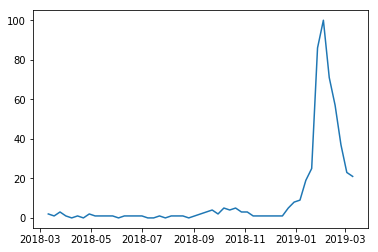

In [26]:
plt.plot(result[' Swine Flu'])

# Swine Flu in Delhi - Search Interest Compared with Fever in Last 30 Days

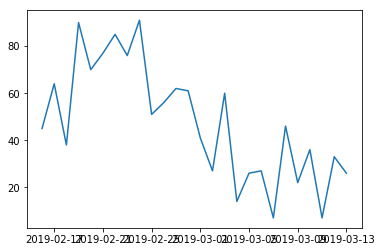

In [27]:
plt.plot(rel_data[' Swine Flu'])

# Comparing Search Interest for All Diseases/Conditions in Delhi (Small Population) 

Trends Score Graph


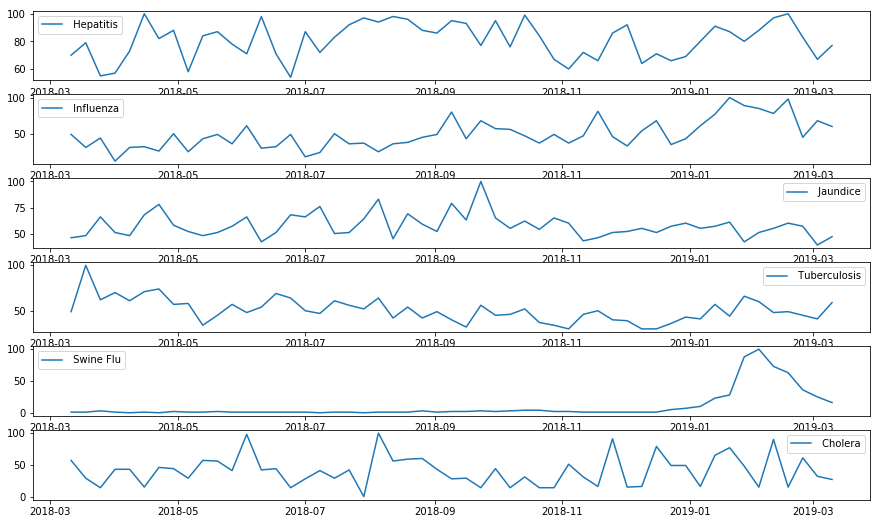

In [34]:
if __name__ == "__main__":
    main()

# Comparing Search Interest for All Diseases/Conditions in Delhi (Large Population Trend)

Relative Score Graph


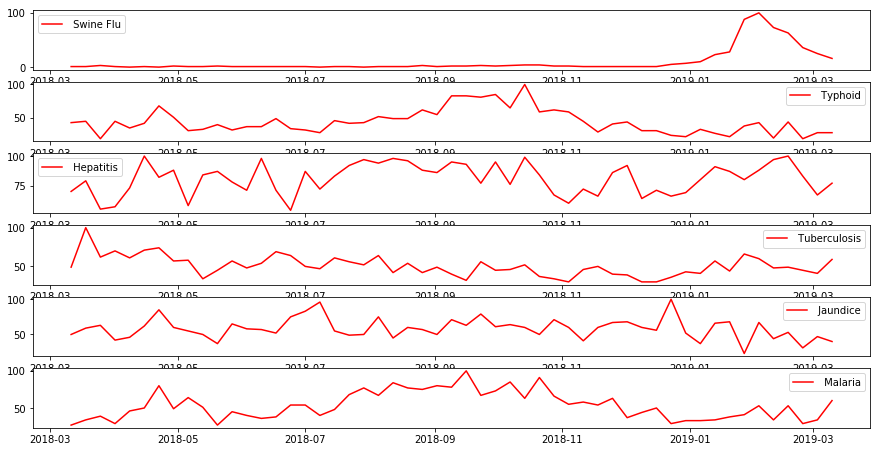

In [36]:
if __name__ == "__main__":
    main()